In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np

import re
import ftfy

from sklearn.metrics import  classification_report, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import load_model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, Dense, LSTM, Embedding, Dropout, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors

In [4]:
DEPRES_NROWS = 30000  
NONDEP_NROWS = 30000

In [5]:
MAX_SEQUENCE_LENGTH = 280
MAX_NB_WORDS = 35000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
EPOCHS= 20
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [6]:
data = pd.read_csv("data.csv", encoding='latin-1')

DATASET_COLUMNS = ["label", "ids", "date", "flag", "user", "tweet"]

data.columns = DATASET_COLUMNS

positive_data = data[data['label'] == 4]
negative_data = data[data['label'] == 0]

columns_to_drop = ["label", "ids", "date", "flag", "user"]
positive_data = positive_data.drop(columns_to_drop, axis=1)
negative_data = negative_data.drop(columns_to_drop, axis=1)

depressive_tweets_df = negative_data.head(DEPRES_NROWS)
non_depressive_tweets_df = positive_data.head(NONDEP_NROWS)

In [7]:
non_depressive_tweets_df.head()

,tweet
799999,I LOVE @Health4UandPets u guys r the best!!
800000,im meeting up with one of my besties tonight! ...
800001,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,Being sick can be really cheap when it hurts t...
800003,@LovesBrooklyn2 he has that effect on everyone


In [8]:
depressive_tweets_df.head()

,tweet
0,is upset that he can't update his Facebook by ...
1,@Kenichan I dived many times for the ball. Man...
2,my whole body feels itchy and like its on fire
3,"@nationwideclass no, it's not behaving at all...."
4,@Kwesidei not the whole crew


In [9]:
emojies = [":‑)", ":)", ":D", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)", "=)", ":}", ":^)", ":っ)", ":‑D", "8‑D", "8D", "x‑D", "xD", "X‑D", "XD", "=‑D", "=D", "=‑3", "=3", "B^D", ":-))", ">:[", ":‑(", ":(", ":‑c", ":c", ":‑<", ":っC", ":<", ":‑[", ":[", ":{", ";(", ":-||", ":@", ">:(", ":'‑(", ":'(", ":'‑)", ":')", "D:<", "D:", "D8", "D;", "D=", "DX", "v.v", "D‑':", ">:O", ":‑O", ":O", ":‑o", ":o", "8‑0", "O_O", "o‑o", "O_o", "o_O", "o_o", "O-O", ":*", ":-*", ":^*", "(", "}{'", ")", ";‑)", ";)", "*-)", "*)", ";‑]", ";]", ";D", ";^)", ":‑,", ">:P", ":‑P", ":P", "X‑P", "x‑p", "xp", "XP", ":‑p", ":p", "=p", ":‑Þ", ":Þ", ":þ", ":‑þ", ":‑b", ":b", "d:", ">:\\", ">:/", ":‑/", ":‑.", ":/", ":\\", "=/", "=\\", ":L", "=L", ":S", ">.<", ":|", ":‑|", ":$", ":‑X", ":X", ":‑#", ":#", "O:‑)", "0:‑3", "0:3", "0:‑)", "0:)", "0;^)", ">:)", ">;)", ">:‑)", "}:‑)", "}:)", "3:‑)", "3:)", "o/\o", "^5", ">_>^", "^<_<", "|;‑)", "|‑O", ":‑J", ":‑&", ":&", "#‑)", "%‑)", "%)", ":‑###..", ":###..", "<:‑|", "<*)))‑{", "><(((*>", "><>", "\o/", "*\0/*", "@}‑;‑'‑‑‑", "@>‑‑>‑‑", "~(_8^(I)", "5:‑)", "~:‑\\", "//0‑0\\\\", "*<|:‑)", "=:o]", "7:^]", ",:‑)", "</3", "<3"]
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)
  
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [10]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            tweet = re.sub(r"http\S+", "", tweet)
            tweet = re.sub(r'www.+', "", tweet)
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            tweet = re.sub(r'\&\w*;', '', tweet)
            tweet = re.sub('@[^\s]+','',tweet)
            tweet = re.sub(r'\$\w*', '', tweet)
            tweet = tweet.lower()
            tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
            tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
            tweet = re.sub(r'\s\s+', ' ', tweet)
            tweet = tweet.lstrip(' ') 
            tweet = ''.join(c for c in tweet if c <= '\uFFFF')
            tweet = ftfy.fix_text(tweet)
            tweet = expandContractions(tweet)
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
            
            neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], tweet)
            letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
            
            words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]

            stop_words = set(stopwords.words('english'))
            stop_words.update(("mon","tue","wed","thu","fri","sat","sun","sunday","monday","tuesday","thursday","friday","saturday","sunday","thurs","thur","tues"))
            stop_words.update(("january","february","march","april","may","june","july","august",
              "september","october","november","december","jan","feb","mar","apr",
              "may","jun","jul","aug","sep","oct","nov","dec", "twitter", "thanking","thanks"))
    
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [11]:
depressive_tweets_arr = [x for x in depressive_tweets_df['tweet']]
non_depressive_tweets_arr = [x for x in non_depressive_tweets_df['tweet']]
X_d = clean_tweets(depressive_tweets_arr)
X_n = clean_tweets(non_depressive_tweets_arr)

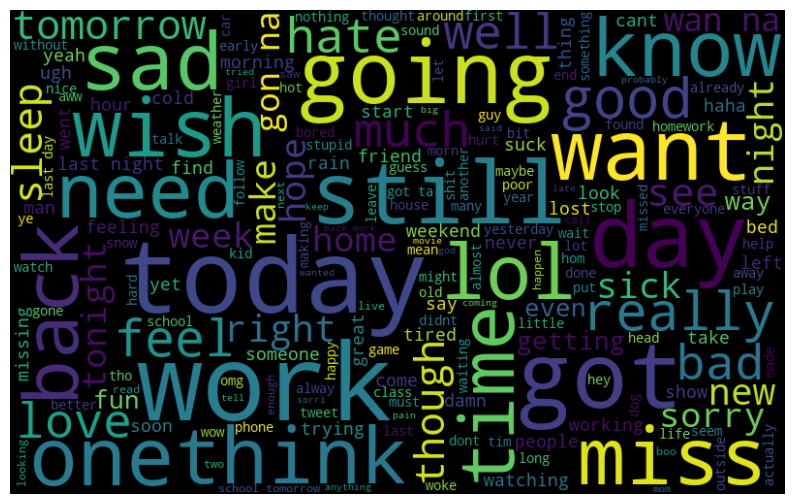

In [12]:
all_words = ' '.join([text for text in X_d])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

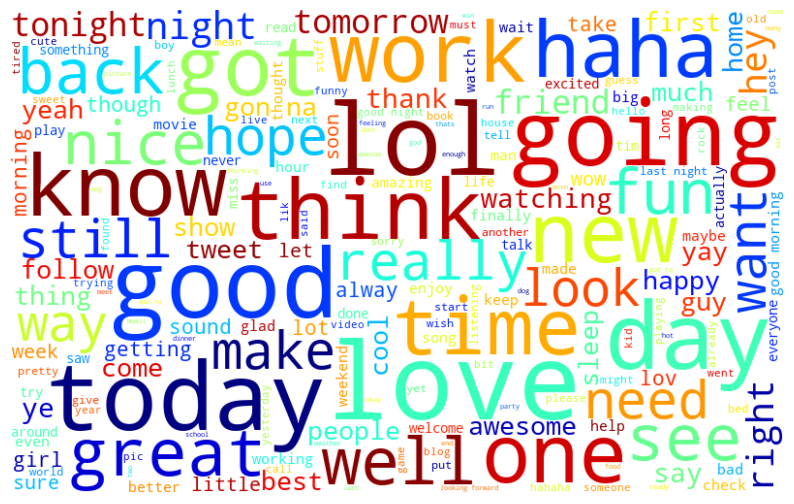

In [13]:
all_words = ' '.join([text for text in X_n])
wordcloud = WordCloud(background_color='white', colormap='jet', width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [14]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_n)
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_n = tokenizer.texts_to_sequences(X_n)

In [15]:
word_index = tokenizer.word_index
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_n = pad_sequences(sequences_n, maxlen=MAX_SEQUENCE_LENGTH)

In [16]:
print('Found %s unique tokens' % len(word_index))

Found 38801 unique tokens


In [17]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [18]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    idx = min(idx, nb_words - 1)
    if word in word2vec.key_to_index:
        embedding_matrix[idx] = word2vec.get_vector(word)

In [19]:
labels_d = np.array([1] * DEPRES_NROWS)
labels_n = np.array([0] * NONDEP_NROWS)

In [20]:
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_n))
idx_train_n = perm_r[:int(len(data_n)*(TRAIN_SPLIT))]
idx_test_n = perm_r[int(len(data_n)*(TRAIN_SPLIT)):int(len(data_n)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_n = perm_r[int(len(data_n)*(TRAIN_SPLIT+TEST_SPLIT)):]

data_train = np.concatenate((data_d[idx_train_d], data_n[idx_train_n]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_n[idx_train_n]))
data_test = np.concatenate((data_d[idx_test_d], data_n[idx_test_n]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_n[idx_test_n]))
data_val = np.concatenate((data_d[idx_val_d], data_n[idx_val_n]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_n[idx_val_n]))

perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [19]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

nadam = optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=0.005)
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['acc'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 300)          10500000  
                                                                 
 conv1d (Conv1D)             (None, 280, 64)           57664     
                                                                 
 max_pooling1d (MaxPooling1  (None, 140, 64)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 140, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 300)               438000    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                      

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=16, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/20


2230/2230 [==============================] - 354s 157ms/step - loss: 0.6209 - acc: 0.6580 - val_loss: 0.5784 - val_acc: 0.7035
Epoch 2/20
2230/2230 [==============================] - 357s 160ms/step - loss: 0.5684 - acc: 0.7068 - val_loss: 0.5560 - val_acc: 0.7157
Epoch 3/20
2230/2230 [==============================] - 359s 161ms/step - loss: 0.5488 - acc: 0.7243 - val_loss: 0.5418 - val_acc: 0.7280
Epoch 4/20
2230/2230 [==============================] - 356s 160ms/step - loss: 0.5380 - acc: 0.7313 - val_loss: 0.5361 - val_acc: 0.7299
Epoch 5/20
2230/2230 [==============================] - 356s 160ms/step - loss: 0.5272 - acc: 0.7375 - val_loss: 0.5313 - val_acc: 0.7315
Epoch 6/20
2230/2230 [==============================] - 355s 159ms/step - loss: 0.5155 - acc: 0.7455 - val_loss: 0.5308 - val_acc: 0.7346
Epoch 7/20
2230/2230 [==============================] - 369s 165ms/step - loss: 0.5095 - acc: 0.7501 - val_loss: 0.5309 - val_acc: 0.7333
Epoch 8/20
2230/2230 [==========

In [21]:
model.save('model.keras')

In [22]:

model = load_model('model.keras')

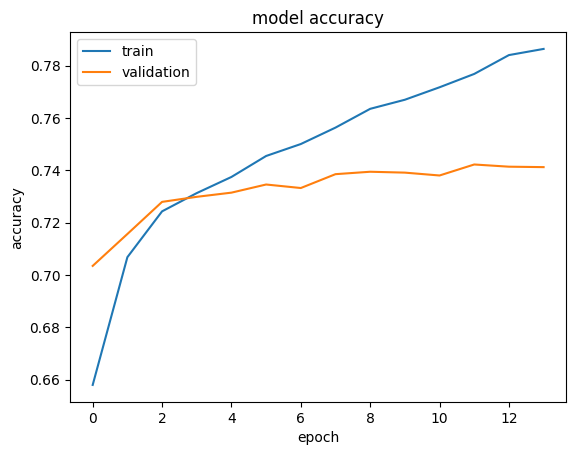

In [23]:
#Results: summarize the history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

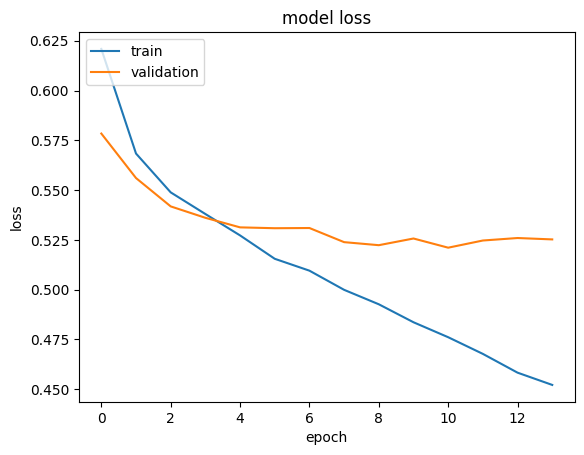

In [24]:
#Summarize for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [25]:
#Percentage accuracy of model
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

372/372 [==============================] - 17s 45ms/step
Accuracy: 74.23%


In [26]:
#f1, precision, and recall scores
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      5938
           1       0.74      0.74      0.74      5954

    accuracy                           0.74     11892
   macro avg       0.74      0.74      0.74     11892
weighted avg       0.74      0.74      0.74     11892



# LOGISTIC REGRESSION

In [1]:
from math import exp
from numpy import sign
LEARNING_RATE = 0.001

In [2]:
class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [21]:
def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

In [23]:

# Training the logistic regression model
logreg = LogReg(LEARNING_RATE, EPOCHS, len(data_train[0]))
bias_logreg, weights_logreg = logreg.train(data_train, labels_train)
y_pred = [round(logreg.predict(example)) for example in data_test]


In [24]:
accuracy_logistic = get_accuracy(y_pred, labels_test)
print('Accuracy: {:0.3f}'.format(accuracy_logistic))

Benchmark Model Accuracy: 50.345


In [25]:
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.18      0.26      5938
           1       0.50      0.83      0.63      5954

    accuracy                           0.50     11892
   macro avg       0.51      0.50      0.44     11892
weighted avg       0.51      0.50      0.44     11892



# RANDOM FOREST

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(data_train, labels_train)

# Model Evaluation
y_pred = rf_classifier.predict(data_test)
accuracy_logistic = get_accuracy(y_pred, labels_test)
print('Accuracy: {:0.3f}'.format(accuracy_logistic))
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      5938
           1       0.69      0.72      0.71      5954

    accuracy                           0.70     11892
   macro avg       0.70      0.70      0.70     11892
weighted avg       0.70      0.70      0.70     11892



# KNN 

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
knn_classifier = KNeighborsClassifier(n_neighbors=2)
knn_classifier.fit(data_train, labels_train)

# Model Evaluation
y_pred = knn_classifier.predict(data_test)
accuracy_logistic = get_accuracy(y_pred, labels_test)
print('Accuracy: {:0.3f}'.format(accuracy_logistic))
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.80      0.67      5938
           1       0.68      0.42      0.52      5954

    accuracy                           0.61     11892
   macro avg       0.63      0.61      0.60     11892
weighted avg       0.63      0.61      0.59     11892



# SVM

In [23]:
from sklearn.svm import SVC

In [24]:
svm_classifier = SVC(kernel='sigmoid')
svm_classifier.fit(data_train, labels_train)

# Model Evaluation
y_pred = svm_classifier.predict(data_test)
accuracy_logistic = get_accuracy(y_pred, labels_test)
print('Accuracy: {:0.3f}'.format(accuracy_logistic))
print(classification_report(labels_test, y_pred))

Accuracy: 50.042
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      5938
           1       0.50      0.50      0.50      5954

    accuracy                           0.50     11892
   macro avg       0.50      0.50      0.50     11892
weighted avg       0.50      0.50      0.50     11892

